In [17]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
datasets = [
    "mendelian_matched_9",
    "gwas_matched_9",
]

subsets = [
    #"all",
    "non_coding",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "Ensemble",
    "CADD",
    "GPN-MSA",
    "NucleotideTransformer",
    "HyenaDNA",
    "Caduceus",
    "GPN",
    "Enformer",
    "Borzoi",
]

def get_model_path(model, modality, dataset, subset):
    supervised_suffix = "LogisticRegression.chrom"
    if model == "CADD":
        predictor = "CADD.plus.RawScore" if modality == "Zero-shot" else f"CADD.{supervised_suffix}"
    elif model in ["Enformer", "Borzoi"]:
        predictor = f"{model}_L2_L2.plus.all" if modality == "Zero-shot" else f"{model}.{supervised_suffix}"
    elif model == "Ensemble":
        if "mendelian" in dataset:
            prefix = "OMIM_Ensemble_v2" 
        else:
            prefix = "Enformer+GPN-MSA+CADD"
        predictor = f"{prefix}.{supervised_suffix}"
    else:
        if "mendelian" in dataset:
            llr_version = "LLR"
            sign = "minus"
        elif "gwas" in dataset:
            llr_version = "absLLR"
            sign = "plus"
        predictor = f"{model}_{llr_version}.{sign}.score" if modality == "Zero-shot" else f"{model}_{llr_version}+InnerProducts.{supervised_suffix}"
    return f"../../results/dataset/{dataset}/metrics/{subset}/{predictor}.csv"

In [11]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if model == "Ensemble" and modality == "Zero-shot":
                    continue
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path).iloc[0]
                rows.append([dataset, subset, modality, model, df["score"], df["se"]])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se"])
df

,dataset,subset,modality,model,score,se
0,mendelian_matched_9,non_coding,Zero-shot,CADD,0.679601,0.037650
1,mendelian_matched_9,non_coding,Zero-shot,GPN-MSA,0.672161,0.043842
2,mendelian_matched_9,non_coding,Zero-shot,NucleotideTransformer,0.102641,0.003891
3,mendelian_matched_9,non_coding,Zero-shot,HyenaDNA,0.101704,0.005260
4,mendelian_matched_9,non_coding,Zero-shot,Caduceus,0.095032,0.002756
5,mendelian_matched_9,non_coding,Zero-shot,GPN,0.328958,0.068334
6,mendelian_matched_9,non_coding,Zero-shot,Enformer,0.364696,0.042894
7,mendelian_matched_9,non_coding,Zero-shot,Borzoi,0.391513,0.053129
8,mendelian_matched_9,non_coding,Linear probing,Ensemble,0.834813,0.027622
9,mendelian_matched_9,non_coding,Linear probing,CADD,0.822779,0.030148


In [12]:
def format_score(x):
    return (x * 100).round().astype(int).apply(lambda y: f"{y:02d}")

def format_se(x):
    assert (x * 100).max() < 10
    return (x * 100).round().astype(int).apply(lambda y: f"{y:01d}")

df["value"] = format_score(df.score) + "$\pm$" + format_se(df.se)
#df["value"] = df.score.apply(lambda x: f"{x:.2f}") + "$\pm$" + df.se.apply(lambda x: f"{x:.2f}")

In [13]:
#df.loc[(df.model.isin(["Enformer", "Borzoi", "GPN"])) & (df.subset!="non_missense"), "value"] = "-"

In [14]:
bold_values = [
    ("mendelian_matched_9", "all", "Zero-shot", "CADD"),
    ("mendelian_matched_9", "all", "Zero-shot", "GPN-MSA"),
    ("mendelian_matched_9", "missense_variant", "Zero-shot", "CADD"),
    ("mendelian_matched_9", "missense_variant", "Zero-shot", "GPN-MSA"),
    ("mendelian_matched_9", "non_missense", "Zero-shot", "CADD"),
    ("mendelian_matched_9", "non_missense", "Zero-shot", "GPN-MSA"),

    ("mendelian_matched_9", "all", "Linear probing", "CADD"),
    ("mendelian_matched_9", "all", "Linear probing", "Ensemble"),
    ("mendelian_matched_9", "missense_variant", "Linear probing", "CADD"),
    ("mendelian_matched_9", "missense_variant", "Linear probing", "Ensemble"),
    ("mendelian_matched_9", "non_missense", "Linear probing", "CADD"),
    ("mendelian_matched_9", "non_missense", "Linear probing", "Ensemble"),

    ("gwas_matched_9", "all", "Zero-shot", "CADD"),
    ("gwas_matched_9", "all", "Zero-shot", "GPN-MSA"),
    ("gwas_matched_9", "missense_variant", "Zero-shot", "CADD"),
    #("gwas_matched_9", "missense_variant", "Zero-shot", "GPN-MSA"),
    ("gwas_matched_9", "non_missense", "Zero-shot", "Enformer"),
    ("gwas_matched_9", "non_missense", "Zero-shot", "Borzoi"),

    ("gwas_matched_9", "all", "Linear probing", "Ensemble"),
    ("gwas_matched_9", "missense_variant", "Linear probing", "Ensemble"),
    ("gwas_matched_9", "non_missense", "Linear probing", "Ensemble"),
]

for dataset, subset, modality, model in bold_values:
    mask = (
        (df.dataset==dataset) & (df.subset==subset) &
        (df.modality==modality) & (df.model==model)
    )
    df.loc[mask, "value"] = r"\textbf{" + df.loc[mask, "value"] + "}"

In [15]:
df.dataset = df.dataset.map({
    "mendelian_matched_9": "Mendelian traits", #r"\textbf{Mendelian traits}",
    "gwas_matched_9": "Complex traits", #r"\textbf{Complex traits}",
})
df.subset = df.subset.map({
    "all": "All",
    "missense_variant": "Coding",
    "non_coding": "Non-coding",
})
#df.modality = df.modality.map({
#    "Zero-shot": r"\textbf{Zero-shot}",
#    "Linear probing": r"\textbf{Linear probing}",
#})

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

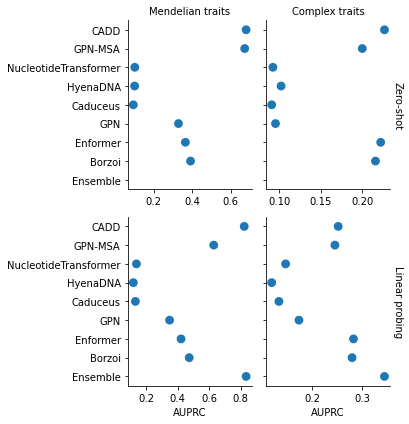

In [23]:
# TODO: get the old plotting code
# TODO: add error bars

g = sns.catplot(
    data=df.rename(columns={"score": "AUPRC"}),
    y="model",
    x="AUPRC",
    row="modality",
    col="dataset",
    #kind="bar",
    kind="point", join=False,
    sharex=False,
    margin_titles=True,
    height=3,
)
g.set(
    ylabel="",
)
g.set_titles(col_template="{col_name}", row_template="{row_name}");

In [8]:
df = df.pivot_table(
    index=["modality", "model"],
    columns=[
        "dataset",
        #"subset",
    ],
    values="value", aggfunc="first", sort=False,
)
df

dataset                                       \textbf{Mendelian traits}  \
modality                model                                             
\textbf{Zero-shot}      CADD                                   68$\pm$4   
                        GPN-MSA                                67$\pm$4   
                        NucleotideTransformer                  10$\pm$0   
                        HyenaDNA                               10$\pm$1   
                        Caduceus                               10$\pm$0   
                        GPN                                    33$\pm$7   
                        Enformer                               36$\pm$4   
                        Borzoi                                 39$\pm$5   
\textbf{Linear probing} CADD                                   82$\pm$3   
                        GPN-MSA                                63$\pm$6   
                        NucleotideTransformer                  14$\pm$2   
                        HyenaDNA                               12$\pm$1   
                        Caduceus                               13$\pm$4   
                        GPN                                    35$\pm$6   
                        Enformer                               42$\pm$4   
                        Borzoi                                 47$\pm$4   
                        Ensemble                               83$\pm$3   

dataset                                       \textbf{Complex traits}  
modality                model                                          
\textbf{Zero-shot}      CADD                                 23$\pm$1  
                        GPN-MSA                              20$\pm$1  
                        NucleotideTransformer                09$\pm$0  
                        HyenaDNA                             10$\pm$0  
                        Caduceus                             09$\pm$0  
                        GPN                                  10$\pm$0  
                        Enformer                             22$\pm$1  
                        Borzoi                               22$\pm$1  
\textbf{Linear probing} CADD                                 25$\pm$1  
                        GPN-MSA                              25$\pm$1  
                        NucleotideTransformer                15$\pm$0  
                        HyenaDNA                             12$\pm$1  
                        Caduceus                             13$\pm$1  
                        GPN                                  17$\pm$1  
                        Enformer                             28$\pm$1  
                        Borzoi                               28$\pm$1  
                        Ensemble                             35$\pm$1

In [9]:
df.index.names = [None, None]
#df.columns.names = [None, None]
df.columns.name = None

In [10]:
print(df.to_latex(multicolumn_format='c', escape=False))

\begin{tabular}{llll}
\toprule
 &  & \textbf{Mendelian traits} & \textbf{Complex traits} \\
\midrule
\multirow[t]{8}{*}{\textbf{Zero-shot}} & CADD & 68$\pm$4 & 23$\pm$1 \\
 & GPN-MSA & 67$\pm$4 & 20$\pm$1 \\
 & NucleotideTransformer & 10$\pm$0 & 09$\pm$0 \\
 & HyenaDNA & 10$\pm$1 & 10$\pm$0 \\
 & Caduceus & 10$\pm$0 & 09$\pm$0 \\
 & GPN & 33$\pm$7 & 10$\pm$0 \\
 & Enformer & 36$\pm$4 & 22$\pm$1 \\
 & Borzoi & 39$\pm$5 & 22$\pm$1 \\
\cline{1-4}
\multirow[t]{9}{*}{\textbf{Linear probing}} & CADD & 82$\pm$3 & 25$\pm$1 \\
 & GPN-MSA & 63$\pm$6 & 25$\pm$1 \\
 & NucleotideTransformer & 14$\pm$2 & 15$\pm$0 \\
 & HyenaDNA & 12$\pm$1 & 12$\pm$1 \\
 & Caduceus & 13$\pm$4 & 13$\pm$1 \\
 & GPN & 35$\pm$6 & 17$\pm$1 \\
 & Enformer & 42$\pm$4 & 28$\pm$1 \\
 & Borzoi & 47$\pm$4 & 28$\pm$1 \\
 & Ensemble & 83$\pm$3 & 35$\pm$1 \\
\cline{1-4}
\bottomrule
\end{tabular}

